In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm, colors

import glob
import gc
import warnings
import copy
import pathlib
import pickle

import os

from scipy import stats
import signac
import freud
import gsd.hoomd
import hoomd
import schmeud
import schmeud._schmeud as schmeud_rs

from dataclasses import dataclass
from collections import defaultdict

import polars as pl

In [6]:
from monk import nb, prep, pair, render, utils, workflow, grid

parent = pathlib.Path(os.getcwd()).parent / "config.yaml"
config = workflow.get_config(parent.as_posix())
parent, config

(PosixPath('/home/ian/Projects/work/monk/workflows/2d-osc-shear/config.yaml'),
 {'root': '/media/ian/Data2/monk/2d-osc-shear',
  'origin': '/media/ian/Data2/monk/2d-esl'})

In [7]:
project: signac.Project = signac.get_project(root=config['root'])
project.doc

{'avail_seed': 18, 'dt': 0.005, 'step_unit': 200, 'equil_time': 100, 'min_periods': 20, 'dumps': 40, 'period_times': [30.0, 100.0, 300.0, 1000.0], 'max_shears': [0.01, 0.02, 0.03, 0.05, 0.08, 0.12], '_status': {}}

In [8]:
@dataclass(frozen=True, eq=True)
class Statepoint:
    max_shear: float
    period: float
    temp: float
    prep: str

In [16]:
# get t1 events
# reversible and irreversible rearrangments

# output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    # if prep != "ESL":
    #     continue
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/t1-events_period-{period}.npz"
        # soft_file = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3:
            continue

        print(max_shear, period, temp)

        if job.isfile(out_path):
            # dataset = pd.read_parquet(job.fn(df_path))
            # output[sp].append(dataset)
            data = dict(np.load(job.fn(out_path), allow_pickle=True))
            len_keys = len(list(data.keys()))
            if "frame" in data:
                len_frame = len(data["frame"])
                if len_keys == 4 and len_frame == 10:
                    print("already done")
                    continue
            print("rerunning")   
            

        traj = gsd.hoomd.open(exper)

        

        frames = []
        rev_out = []
        irr_out = []
        nlists = []
        voro = freud.locality.Voronoi()
        get_frame = lambda cycle, part: cycle*40 + -1 + part*10
        for idx in range(70, 80):

            rearranged = set()

            frames.append(get_frame(idx, 0))

            snap_0 = traj[get_frame(idx, 0)] # initial state
            snap_1 = traj[get_frame(idx, 1)] # peak
            snap_2 = traj[get_frame(idx, 2)] # back to zero
            snap_3 = traj[get_frame(idx, 3)] # min peak
            snap_4 = traj[get_frame(idx, 4)] # full cycle complete

            box_0 = snap_0.configuration.box[:]
            box_1 = snap_1.configuration.box[:]
            box_2 = snap_2.configuration.box[:]
            box_3 = snap_3.configuration.box[:]
            box_4 = snap_4.configuration.box[:]

            voro.compute((box_0, snap_0.particles.position))
            nlist = voro.nlist
            neighbors = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])

            next_to_process = zip([box_1, box_2, box_3, box_4], [snap_1, snap_2, snap_3, snap_4])

            for box, snap in next_to_process:
                voro.compute((box, snap.particles.position))
                nlist = voro.nlist
                neighbors_ = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])
                rearranged |= neighbors - neighbors_
            rev = rearranged & neighbors_
            irr = rearranged - rev
            rev = np.array([list(r) for r in rev])
            irr = np.array([list(r) for r in irr])
            rev_out.append(rev)
            irr_out.append(irr)
            nlists.append(np.array([list(r) for r in neighbors]))
            # break
        dataset = {"frame": frames, "nlist": nlists, "t1_rev": rev_out, "t1_irr": irr_out}
        # np.savez(job.fn(out_path), **dataset)
        # soft_dataset = pl.read_parquet(job.fn(soft_file))
        # break
        # output[sp].append(dataset)
    # break

# save to pickle
# with open(project.fn("results/t1-counts_period-1000.pkl"), "wb") as f:
#     pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb
0.01 1000.0 1.9836e-03
rerunning


/home/ian/Projects/work/monk/.venv/lib/python3.10/site-packages/numpy/lib/npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)


0.02 1000.0 1.9836e-03
rerunning
0.03 1000.0 1.9836e-03
already done
0.05 1000.0 1.9836e-03
rerunning
0.08 1000.0 1.9836e-03
already done
0.12 1000.0 1.9836e-03
rerunning
7ec2f6aca035e69077eab24383a21cb6
0.01 1000.0 1.9836e-03
already done
0.02 1000.0 1.9836e-03
already done
0.03 1000.0 1.9836e-03
already done
0.05 1000.0 1.9836e-03
rerunning
0.08 1000.0 1.9836e-03
already done
0.12 1000.0 1.9836e-03
rerunning
cfa1e4c0007fd65d020f809715a6f0b4
0.01 1000.0 1.9836e-03
already done
0.02 1000.0 1.9836e-03
already done
0.03 1000.0 1.9836e-03
already done
0.05 1000.0 1.9836e-03
already done
0.08 1000.0 1.9836e-03
already done
0.12 1000.0 1.9836e-03
already done
ecce68c50e28a33684826f28780bf6e9
0.01 1000.0 1.9836e-03
already done
0.02 1000.0 1.9836e-03
already done
0.03 1000.0 1.9836e-03
already done
0.05 1000.0 1.9836e-03
already done
0.08 1000.0 1.9836e-03
already done
0.12 1000.0 1.9836e-03
already done
1d0fe2ba44a6f635f5504dcbcee0ebc9
0.01 1000.0 1.9836e-03
already done
0.02 1000.0 1.9836e

In [12]:
# get t1 events
# reversible and irreversible rearrangments

# output = defaultdict(list)

for job in project:
    print(job)
    prep = job.sp["prep"]
    if prep != "HTL":
        continue
    
    experiments = sorted(glob.glob(job.fn("aqs_therm_experiments/*/*/traj-fire_period-*.gsd")))

    for exper in experiments:
        max_shear = utils.extract_between(exper, "max-shear-", "/")
        period = utils.extract_between(exper, "period-", ".gsd")
        temp = utils.extract_between(exper, "temp-", "/")
        out_path = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/t1-events-trans_period-{period}.npz"
        soft_file = f"aqs_therm_experiments/max-shear-{max_shear}/temp-{temp}/strob-softness_period-{period}.parquet"
        sp = Statepoint(max_shear=float(max_shear), period=float(period), temp=float(temp), prep=prep)
        
        if float(period) != 1000.0 or float(temp) > 5e-3 or float(max_shear) != 0.05:
            continue

        print(max_shear, period, temp)

        # if job.isfile(out_path):
        #     # dataset = pd.read_parquet(job.fn(df_path))
        #     # output[sp].append(dataset)
        #     data = dict(np.load(job.fn(out_path), allow_pickle=True))
        #     len_keys = len(list(data.keys()))
        #     if "frame" in data:
        #         len_frame = len(data["frame"])
        #         if len_keys == 4 and len_frame == 10:
        #             print("already done")
        #             continue
        #     print("rerunning")   
            

        traj = gsd.hoomd.open(exper)

        

        frames = []
        rev_out = []
        irr_out = []
        nlists = []
        voro = freud.locality.Voronoi()
        get_frame = lambda cycle, part: cycle*40 + -1 + part*10
        for idx in range(1, 11):

            rearranged = set()

            frames.append(get_frame(idx, 0))

            snap_0 = traj[get_frame(idx, 0)] # initial state
            snap_1 = traj[get_frame(idx, 1)] # peak
            snap_2 = traj[get_frame(idx, 2)] # back to zero
            snap_3 = traj[get_frame(idx, 3)] # min peak
            snap_4 = traj[get_frame(idx, 4)] # full cycle complete

            box_0 = snap_0.configuration.box[:]
            box_1 = snap_1.configuration.box[:]
            box_2 = snap_2.configuration.box[:]
            box_3 = snap_3.configuration.box[:]
            box_4 = snap_4.configuration.box[:]

            voro.compute((box_0, snap_0.particles.position))
            nlist = voro.nlist
            neighbors = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])

            next_to_process = zip([box_1, box_2, box_3, box_4], [snap_1, snap_2, snap_3, snap_4])

            for box, snap in next_to_process:
                voro.compute((box, snap.particles.position))
                nlist = voro.nlist
                neighbors_ = set([frozenset([min(i, j), max(i, j)]) for i, j in zip(nlist.query_point_indices, nlist.point_indices)])
                rearranged |= neighbors - neighbors_
            rev = rearranged & neighbors_
            irr = rearranged - rev
            rev = np.array([list(r) for r in rev])
            irr = np.array([list(r) for r in irr])
            rev_out.append(rev)
            irr_out.append(irr)
            nlists.append(np.array([list(r) for r in neighbors]))
            break
        dataset = {"frame": frames, "nlist": nlists, "t1_rev": rev_out, "t1_irr": irr_out}
        np.savez(job.fn(out_path), **dataset)
        soft_dataset = pl.read_parquet(job.fn(soft_file))
        break
        # output[sp].append(dataset)
    break

# save to pickle
# with open(project.fn("results/t1-counts_period-1000.pkl"), "wb") as f:
#     pickle.dump(output, f)

634e14bc75836df75158fb15f379d8bb
0.05 1000.0 1.9836e-03


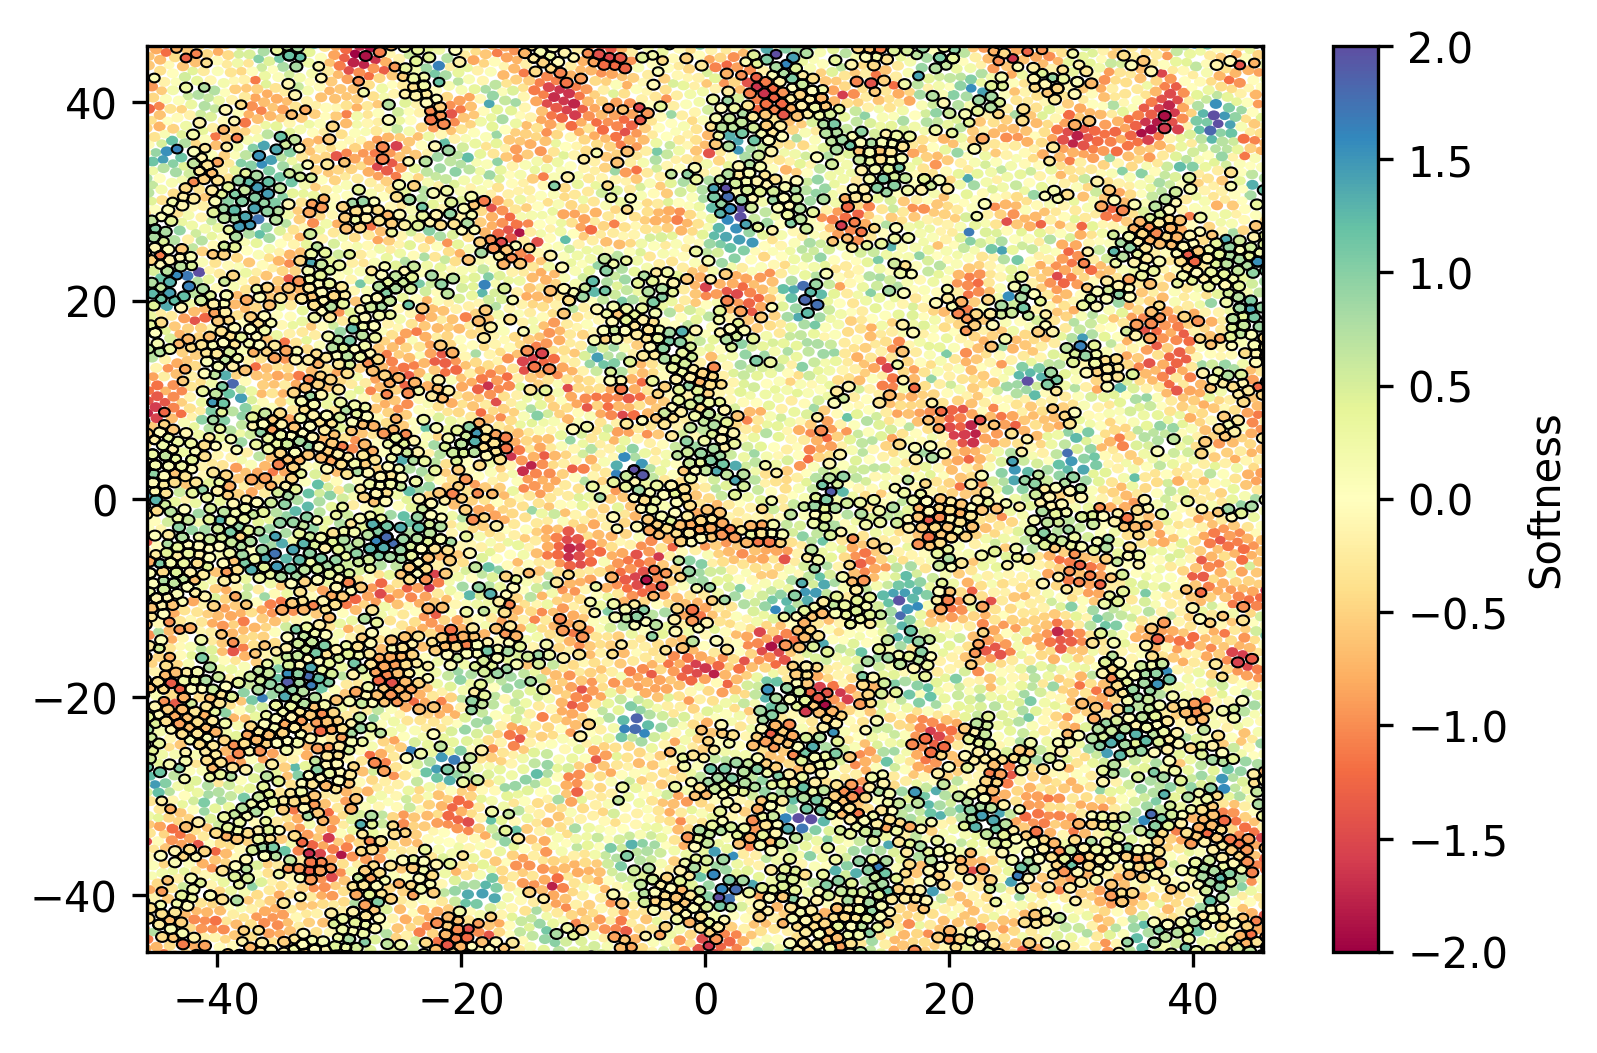

In [13]:
# mark t1 events

from matplotlib.collections import PatchCollection
from matplotlib.patches import Circle
import matplotlib.pyplot as plt

snap = snap_0

# extract particle positions and data
positions = snap.particles.position
diams = snap.particles.diameter
color_data = soft_dataset[idx - 1]["soft"].to_numpy()[0]

# create a list of circles with positions and radius
circles = [Circle((x[0], x[1]), radius=d/2.0) for x, d in zip(positions, diams)]

# create a patch collection with circles and color data
# norm = colors.LogNorm(vmax=100)
norm = colors.Normalize(-2, 2)
import seaborn as sns
cmap = sns.color_palette("Spectral", as_cmap=True)
collection = PatchCollection(circles, cmap=cmap, norm=norm)
collection.set_array(color_data)
# norm2 = colors.Normalize(vmin=np.quantile(abs_data, 0.2), vmax=np.quantile(abs_data, 0.8))
# alpha = norm2(abs_data)
# # clamp between 0 and 1
# alpha = np.clip(alpha, 0, 1)
# collection.set_alpha(alpha)

# plot particles with color
fig, ax = plt.subplots(dpi=150)
ax.add_collection(collection)

rev_patches = []
for r in irr:
    rev_patches.append(Circle((positions[r[0]][0], positions[r[0]][1]), radius=diams[r[0]]/2.0))
    rev_patches.append(Circle((positions[r[1]][0], positions[r[1]][1]), radius=diams[r[1]]/2.0))

rev_col = PatchCollection(rev_patches, facecolor="none", edgecolor="black", linewidth=0.5)
ax.add_collection(rev_col)

ax.autoscale()

# zoom in 5x
zoom = 2
xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.set_xlim((xlim[0] + xlim[1])/2 - (xlim[1] - xlim[0])/zoom/2, (xlim[0] + xlim[1])/2 + (xlim[1] - xlim[0])/zoom/2)
ax.set_ylim((ylim[0] + ylim[1])/2 - (ylim[1] - ylim[0])/zoom/2, (ylim[0] + ylim[1])/2 + (ylim[1] - ylim[0])/zoom/2)

plt.colorbar(collection, label="Softness")

plt.show()
